# imaga data generator: 원본데이터 사용 안함!!!
- 원본 데이터와 뻥튀기한 데이터를 함께 사용하면
- 여러번 원본 데이터가 포함되기 때문에
- 원본데이터: 학습 안하고, 뻥튀기하는 용도로만 사용!!!

> 섞어쓰는 방법도 있음
- 원본 데이터로만 pretrain 모델 만들고! generator해서 finetuning 할 수도 있음.!!!!!
- 좋은 출발점에서 시작하는 것!!!


- save하고 또 generator하는  방법은 좋지 않음.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
import tensorflow as tf
import numpy as np
from numpy  import expand_dims
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
np.random.seed(15)

Using TensorFlow backend.


# 1. dataset

## 1.1. img 불러와서 저장해보기

In [5]:
np.random.seed(5)


# 데이터셋 불러오기
data_aug_gen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.5,
                                  zoom_range=[0.8, 2.0],
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
# keras로 불러오기                                   
img = load_img('hard_handwriting_shape/train/triangle/triangle001.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0

# 이 for는 무한으로 반복되기 때문에 우리가 원하는 반복횟수를 지정하여, 
#지정된 반복횟수가 되면 빠져나오도록 해야합니다.
# 30번 저장(batch size = 1)
for batch in data_aug_gen.flow(x, 
                               batch_size=1, 
                               save_to_dir='./hard_handwriting_shape/tmp/', 
                               save_prefix='tri', 
                               save_format='png'):
    i += 1
    if i > 30: 
        break
        

## 1.2. image data generator 

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   shuffle = True, # batch 학습이므로 무조건 섞기
                                  )

train_generator = train_datagen.flow_from_directory(
        'hard_handwriting_shape/train/',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical',# one-hot encoding사용
        )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'hard_handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical', shuffle=False)

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


> shuffle
- train : True
- test: False 가 관행!

# 2. model

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



# 3. train: fit_generator
- 배치단위로 데이터를 업데이트하면서 생성해서 학습하기

In [13]:
# 모델 학습시키기
model.fit_generator(
        train_generator,
        # epoch 1번 할 때마다 만드어지는 데이터 수
        steps_per_epoch=15 * 100,
        epochs=10, #200
        validation_data=test_generator,
        validation_steps=5)

Epoch 1/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0229 - accuracy: 0.9949 - val_loss: 1.1921e-07 - val_accuracy: 0.8000
Epoch 2/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 2.7735e-05 - val_accuracy: 0.8000
Epoch 3/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0236 - accuracy: 0.9960 - val_loss: 7.9473e-08 - val_accuracy: 0.8667
Epoch 4/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0000e+00 - val_accuracy: 0.8667
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0148 - accuracy: 0.9962 - val_loss: 0.0000e+00 - val_accuracy: 0.8667
Epoch 6/10
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 3.9736e-08 - val_accuracy: 0.8667
Epoch 7/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0161 - accuracy: 0.9973 - 

> batch size, steps per epoch의 관계
- batch_size=3,
- steps per epoch = 1500
- 45개의 데이터를 1500개로 datagenerator로 늘린 후, barch size만큼 학습하는 의미?!

# 4. model.predict_generator()

In [14]:
# 모델 예측하기
print("-- Predict --")
output = model.predict_generator(test_generator,  steps = 5)    
# batch 사이즈가 3 , 15개가 생성됨
print(output)

T = test_generator.classes
print(T)
p = np.argmax(output, axis=1)
print(p)

sum((T == p)*1) / len(T)

-- Predict --
[[1.95361793e-01 8.04638267e-01 1.50792961e-10]
 [1.34756365e-05 5.19045535e-03 9.94796097e-01]
 [9.99999642e-01 9.58689955e-17 3.64556797e-07]
 [1.00000000e+00 1.12088970e-18 4.52654831e-16]
 [1.00000000e+00 7.57065872e-16 1.30737543e-13]
 [1.29920288e-08 1.00000000e+00 5.16057974e-14]
 [4.48228118e-14 8.08970621e-13 1.00000000e+00]
 [1.56055372e-13 1.00000000e+00 4.11692458e-10]
 [7.81647750e-12 1.00000000e+00 9.02572288e-12]
 [4.79161972e-03 9.95200038e-01 8.27804615e-06]
 [1.33155877e-15 2.14106025e-11 1.00000000e+00]
 [5.50369225e-27 7.88541971e-27 1.00000000e+00]
 [2.76933815e-06 1.55670875e-06 9.99995708e-01]
 [8.93003717e-19 3.40053124e-35 1.00000000e+00]
 [2.40019573e-28 2.52360316e-34 1.00000000e+00]]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[1 2 0 0 0 1 2 1 1 1 2 2 2 2 2]


0.8

# 5. model.evaluate_generator()

In [15]:
# 모델 평가하기
scores = model.evaluate_generator( test_generator, steps = 5)
print(scores[1])

0.800000011920929


# 6. 개선 방향, 해석

- 조금 헷갈리는지, 많이 헷갈리는지 살펴보면서 
- 개선 방안을 봐야 함.

In [21]:
output

array([[1.95361793e-01, 8.04638267e-01, 1.50792961e-10],
       [1.34756365e-05, 5.19045535e-03, 9.94796097e-01],
       [9.99999642e-01, 9.58689955e-17, 3.64556797e-07],
       [1.00000000e+00, 1.12088970e-18, 4.52654831e-16],
       [1.00000000e+00, 7.57065872e-16, 1.30737543e-13],
       [1.29920288e-08, 1.00000000e+00, 5.16057974e-14],
       [4.48228118e-14, 8.08970621e-13, 1.00000000e+00],
       [1.56055372e-13, 1.00000000e+00, 4.11692458e-10],
       [7.81647750e-12, 1.00000000e+00, 9.02572288e-12],
       [4.79161972e-03, 9.95200038e-01, 8.27804615e-06],
       [1.33155877e-15, 2.14106025e-11, 1.00000000e+00],
       [5.50369225e-27, 7.88541971e-27, 1.00000000e+00],
       [2.76933815e-06, 1.55670875e-06, 9.99995708e-01],
       [8.93003717e-19, 3.40053124e-35, 1.00000000e+00],
       [2.40019573e-28, 2.52360316e-34, 1.00000000e+00]], dtype=float32)

## 6.1. predict값에 255를 곱해서 보기
- predict: 각 클래스일 확률값

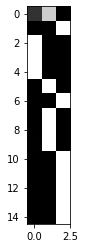

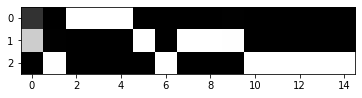

In [20]:
img = output *255
plt.imshow(img, cmap = 'gray')
plt.show()
plt.imshow(img.T, cmap = 'gray')
plt.show()

> 해석
- 앞의 5개부터 circle: 틀린 애들: 헷갈리는 구나
- ractangle: 틀린애들: 아주 엉뚱하가게
- triangle: 틀린 애들- 아주 엉뚱한 얘기

## 6.2 막대그래프로 그리기
- 틀린 애들만 보거나
- 정답 확률와 오답 확률의 차이가 얼마 안나면: wieght값에 따라 틀릴수도 있고, 맞힐 수도 있음.
- 효과적임.

## bar그래프로 확률값 표시하기
- 잘 분류한 것. vs  잘못 분류한 것
- 어떤 테스트 데이터 인데, 어떻게 잘못 인식했는지
- 무엇을 어려워하고, 무엇을 쉽게 구분하는지
- 잘 틀리는 부분에 대해서 데이터 보충하기

# 무엇이 문제 인지 분석한다

In [28]:

output = model.predict_generator(test_generator,  steps = 5)    


In [26]:
T = test_generator.classes
print(T)
p = np.argmax(output, axis=1)
print(p)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[1 2 0 0 0 1 2 1 1 1 2 2 2 2 2]


In [29]:
labels = ['C', 'R', 'T']   

## 맞는것, 틀린것을 구분해서 그리기

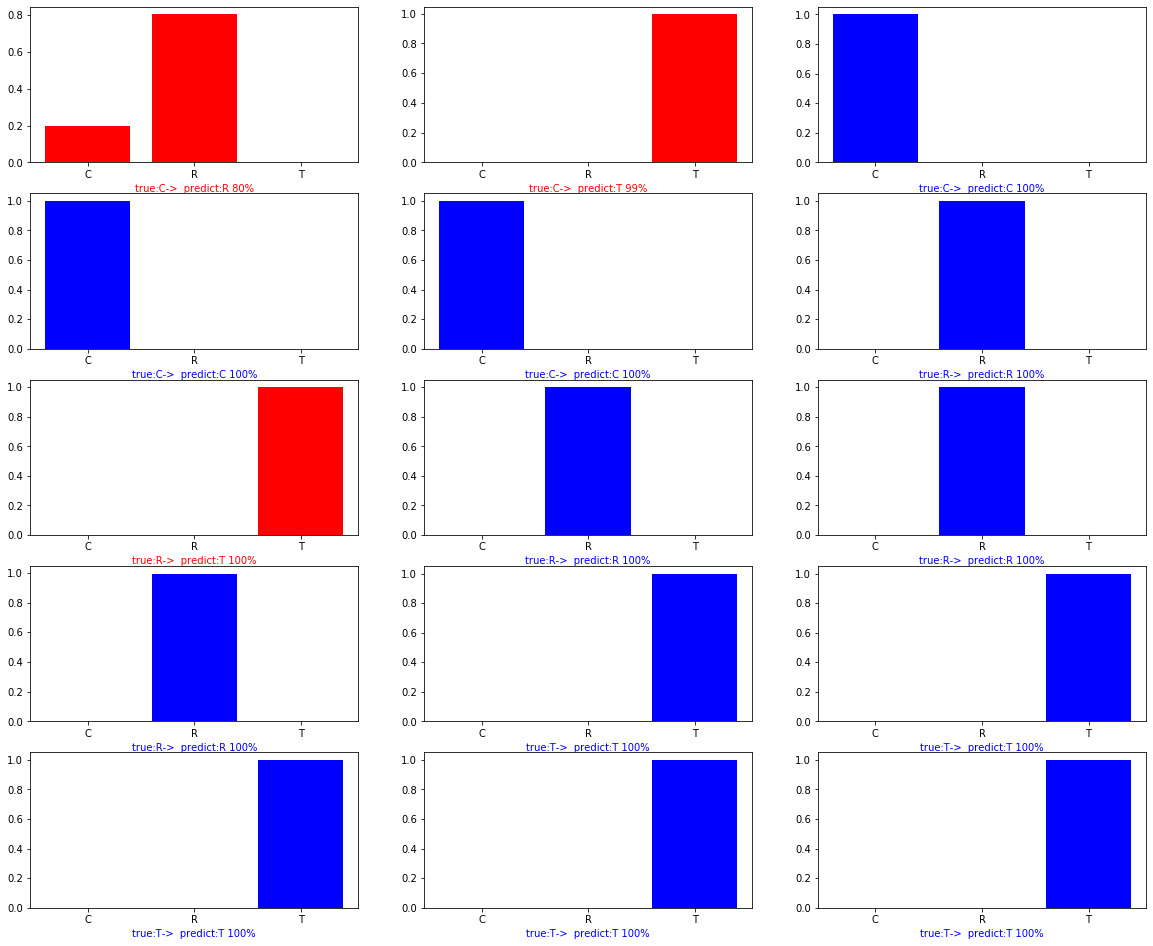

In [39]:
idx = list(range(0,15))

plt.figure(figsize=(20, 20))

cc = 3
rr = int(len(idx) / cc)+1  # 5

for k in range( len(idx) ) :        
    i = idx[k]             
    c =  "blue" if  p[i] == T[i]   else "red"    
    plt.subplot( rr ,cc, k+1)
    plt.bar(labels, output[i], color=c)
    plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[i])], 
                                                       labels[p[  i ]],  
                                                       100*np.max(output[i], axis=0)),  
                                                       color = c )

> 해석
- 맞출 때 확실히 맞췄는지
- 틀린게 어떤 모양을 잘 인식하지 못하는지 등등을 봐야 함.

## 이미지와 함께 보기

### text data 갖고오기

In [64]:
test_generator = test_datagen.flow_from_directory(
                                                './hard_handwriting_shape/test',
                                                target_size=(24, 24),    
                                                batch_size=15,
                                                class_mode='categorical', 
                                                shuffle=False)
a = test_generator.next()
print(a[0].shape, a[1].shape)
X_test =a[0]

Found 15 images belonging to 3 classes.
(15, 24, 24, 3) (15, 3)


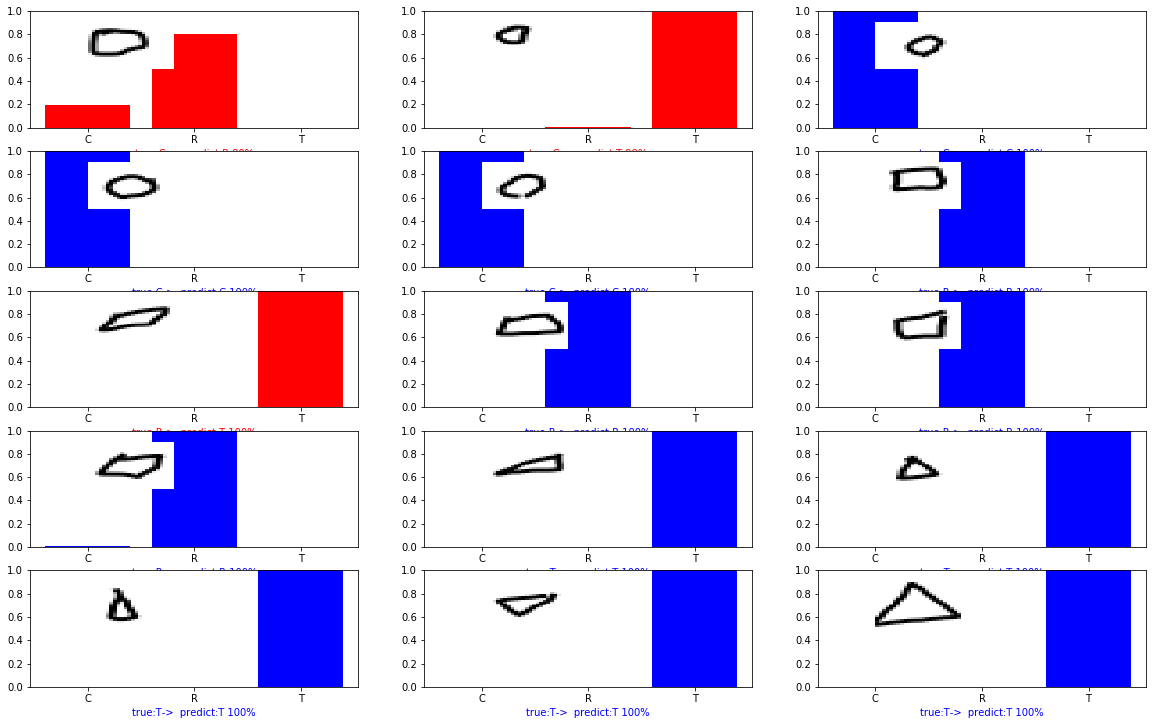

In [68]:
plt.figure(figsize=(20, 15))

cc = 3
rr = int(len(idx) / cc)+1

for k in range( len(idx) ) :        
    i = idx[k]             
    c =  "blue" if  p[i] == T[i]   else "red"    
    plt.subplot( rr ,cc, k+1)
    #  left and right limits, and the bottom and top limits. 
    plt.imshow(X_test[i,:,:,0], extent=[0, 0.8, 0.5, 0.9], aspect='auto', zorder=10, cmap="gray")
    plt.ylim(0.0, 1.0)  
    plt.bar(labels, output[i], color=c)
    plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[  i ])],
                                                     labels[p[  i ]],  
                                                     100*np.max(output[i], axis=0)),  
                                                     color = c )
    
plt.savefig('fig1.png')

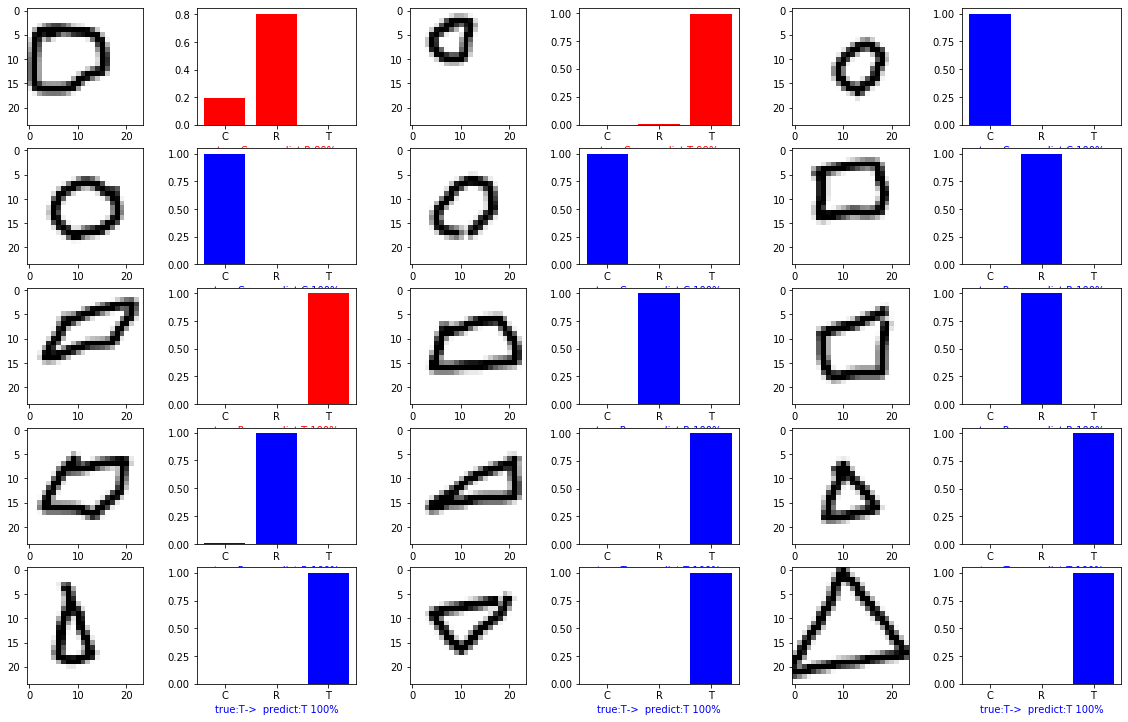

In [71]:
plt.figure(figsize=(20, 15))

cc = 3
rr = int(len(idx) / cc)+1

for k in range( len(idx) ) :        
  i = idx[k]             
  c =  "blue" if  p[i] == T[i]   else "red"    
  plt.subplot( rr ,cc*2, k*2+1)    
  plt.imshow(X_test[i, :,:, 0], cmap="gray") 
  plt.subplot( rr ,cc*2, k*2+2)
  plt.bar(labels, output[i], color=c)
  plt.xlabel("true:{}->  predict:{} {:2.0f}%".format(labels[int(T[i])], 
                                                     labels[p[i]],  
                                                     100*np.max(output[i], axis=0)),  
                                                     color = c )